In [1]:
from pathlib import Path

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
!rm -r ./scores

In [3]:
%%capture

s3_prefix = "s3://nnedl-core-prd-eu-central-1-curated/compbiosandbox/Projects/NNRCO_KG/Sprint_3_3_IR_Paper/Result_lists"

!aws s3 cp "s3://nnedl-core-prd-eu-central-1-curated/compbiosandbox/Projects/NNRCO_KG/Sprint_3_3_IR_Paper/Result_lists" ./scores --recursive

In [2]:
scores_dir = Path('scores')

graphs = ['Hetionet', 'enrichedHetionet', 'OBL', 'enrichedOBL']
test_sets = ['SmallTS', 'LargeTS']
test_set_map = {'SmallTS': 'Small', 'LargeTS': 'Large'}
# output_sets = ['TestSet', 'WholeSet']
output_sets = ['TestSet', ]
output_set_map = {'TestSet': 'Test'}
embedding_methods = ['TransE', 'CompGCN', 'RotatE']
pul_methods = ['Elkanoto', 'Elkanoto_XGBoost', 'IsolationForest', 'LocalOutlierFactor']
score_names = ['hits@10', 'hits@100', 'mr', 'mrr', 'amri', 'tp', 'fp', 'fn', 'tn']

methods = [
    'Topology',
    *embedding_methods,
    *[f'{pm}_{em}' for pm in pul_methods for em in embedding_methods]
]

In [3]:
def get_embedding_method(method_name):
    *_, em_name = method_name.split('_')
    
    return em_name

def get_learner_method(method_name):
    l_name, *_ = method_name.split('_')
    
    return l_name

In [4]:
d = {
    'Graph': [],
    'Positive Set': [],
    'Output Set': [],
    'Method': [],
    'Embedding Method': [],
    'Learner': [],
    'Hits@10': [],
    'Hits@100': [],
    'mr': [],
    'mrr': [],
    'amri': [],
}
for g in graphs:
    for ts in test_sets:
        for m in methods:
            for o_set in output_sets:
                scores_file = scores_dir / g / ts / m / o_set / 'scores.csv'
                if not scores_file.exists():

                    d['Graph'].append(g)
                    d['Positive Set'].append(test_set_map[ts])
                    d['Output Set'].append(output_set_map[o_set])
                    d['Method'].append(m)
                    d['Embedding Method'].append(get_embedding_method(m))
                    d['Learner'].append(get_learner_method(m))
                    d['Hits@10'].append(None)
                    d['Hits@100'].append(None)
                    d['mr'].append(None)
                    d['mrr'].append(None)
                    d['amri'].append(None)
                else:
                    s_df = pd.read_csv(scores_file)
                    for i in range(1,11):
                        d['Graph'].append(g)
                        d['Positive Set'].append(test_set_map[ts])
                        d['Output Set'].append(output_set_map[o_set])
                        d['Method'].append(m)
                        d['Embedding Method'].append(get_embedding_method(m))
                        d['Learner'].append(get_learner_method(m))
                        d['Hits@10'].append(s_df.iloc[0, i])
                        d['Hits@100'].append(s_df.iloc[1, i])
                        d['mr'].append(s_df.iloc[2, i])
                        d['mrr'].append(s_df.iloc[3, i])
                        d['amri'].append(s_df.iloc[4, i])
df = pd.DataFrame(d)
df['Positive Training Set'] = df['Positive Set']
df

,Graph,Positive Set,Output Set,Method,Embedding Method,Learner,Hits@10,Hits@100,mr,mrr,amri,Positive Training Set
0,Hetionet,Small,Test,Topology,Topology,Topology,NaN,NaN,NaN,NaN,NaN,Small
1,Hetionet,Small,Test,TransE,TransE,TransE,0.0,1.0,4384.680672,0.001797,0.540832,Small
2,Hetionet,Small,Test,TransE,TransE,TransE,0.0,4.0,4760.514286,0.001117,0.501465,Small
3,Hetionet,Small,Test,TransE,TransE,TransE,0.0,3.0,4916.339496,0.001739,0.485143,Small
4,Hetionet,Small,Test,TransE,TransE,TransE,1.0,2.0,5234.964706,0.001148,0.451769,Small
...,...,...,...,...,...,...,...,...,...,...,...,...
1131,enrichedOBL,Large,Test,LocalOutlierFactor_RotatE,RotatE,LocalOutlierFactor,0.0,3.0,2039.168000,0.001377,-0.045214,Large
1132,enrichedOBL,Large,Test,LocalOutlierFactor_RotatE,RotatE,LocalOutlierFactor,1.0,3.0,2159.760000,0.001943,-0.107056,Large
1133,enrichedOBL,Large,Test,LocalOutlierFactor_RotatE,RotatE,LocalOutlierFactor,0.0,3.0,2532.152000,0.001155,-0.298027,Large
1134,enrichedOBL,Large,Test,LocalOutlierFactor_RotatE,RotatE,LocalOutlierFactor,2.0,5.0,2278.440000,0.003503,-0.167918,Large


In [5]:
df_agg = df.groupby(['Graph', 'Positive Set', 'Output Set', 'Method', 'Embedding Method', 'Learner']).mean()

/tmp/ipykernel_3646973/2366546201.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_agg = df.groupby(['Graph', 'Positive Set', 'Output Set', 'Method', 'Embedding Method', 'Learner']).mean()


In [6]:
df_agg.to_csv('scores_agg.csv')
df_agg.T.to_csv('scores_agg_t.csv')

In [7]:
df_agg.query('Method == "Topology"')

Hits@10  \
Graph            Positive Set Output Set Method   Embedding Method Learner             
Hetionet         Large        Test       Topology Topology         Topology      NaN   
                 Small        Test       Topology Topology         Topology      NaN   
OBL              Large        Test       Topology Topology         Topology      8.0   
                 Small        Test       Topology Topology         Topology      4.0   
enrichedHetionet Large        Test       Topology Topology         Topology      NaN   
                 Small        Test       Topology Topology         Topology      NaN   
enrichedOBL      Large        Test       Topology Topology         Topology      8.7   
                 Small        Test       Topology Topology         Topology      4.7   

                                                                             Hits@100  \
Graph            Positive Set Output Set Method   Embedding Method Learner              
Hetionet         Large        Test       Topology Topology         Topology       NaN   
                 Small        Test       Topology Topology         Topology       NaN   
OBL              Large        Test       Topology Topology         Topology      50.1   
                 Small        Test       Topology Topology         Topology      12.0   
enrichedHetionet Large        Test       Topology Topology         Topology       NaN   
                 Small        Test       Topology Topology         Topology       NaN   
enrichedOBL      Large        Test       Topology Topology         Topology      57.5   
                 Small        Test       Topology Topology         Topology      12.0   

                                                                                     mr  \
Graph            Positive Set Output Set Method   Embedding Method Learner                
Hetionet         Large        Test       Topology Topology         Topology         NaN   
                 Small        Test       Topology Topology         Topology         NaN   
OBL              Large        Test       Topology Topology         Topology  307.414286   
                 Small        Test       Topology Topology         Topology  909.878151   
enrichedHetionet Large        Test       Topology Topology         Topology         NaN   
                 Small        Test       Topology Topology         Topology         NaN   
enrichedOBL      Large        Test       Topology Topology         Topology  304.612605   
                 Small        Test       Topology Topology         Topology  888.927731   

                                                                                  mrr  \
Graph            Positive Set Output Set Method   Embedding Method Learner              
Hetionet         Large        Test       Topology Topology         Topology       NaN   
                 Small        Test       Topology Topology         Topology       NaN   
OBL              Large        Test       Topology Topology         Topology  0.034915   
                 Small        Test       Topology Topology         Topology  0.019245   
enrichedHetionet Large        Test       Topology Topology         Topology       NaN   
                 Small        Test       Topology Topology         Topology       NaN   
enrichedOBL      Large        Test       Topology Topology         Topology  0.036424   
                 Small        Test       Topology Topology         Topology  0.016385   

                                                                                 amri  
Graph            Positive Set Output Set Method   Embedding Method Learner             
Hetionet         Large        Test       Topology Topology         Topology       NaN  
                 Small        Test       Topology Topology         Topology       NaN  
OBL              Large        Test       Topology Topology         Topology  0.843427  
                 Small        Test       Topology Topology     

In [8]:
df.to_csv('scores.csv', index=False)

In [9]:
grps = [(g_name, g_df) for g_name, g_df in df.groupby('Graph')]

In [10]:
def plot_df(g_df, g_name, y_lim = (0, 105), y='Hits@100'):
    fig = plt.figure()
    plot = sns.boxplot(g_df, y=y, x='Method', hue='Positive Training Set')
    plot.set_xticklabels(labels=plot.get_xticklabels(), rotation=90)
    plot.set_ylim(y_lim)
    fig.suptitle(g_name)
    
    return fig, plot

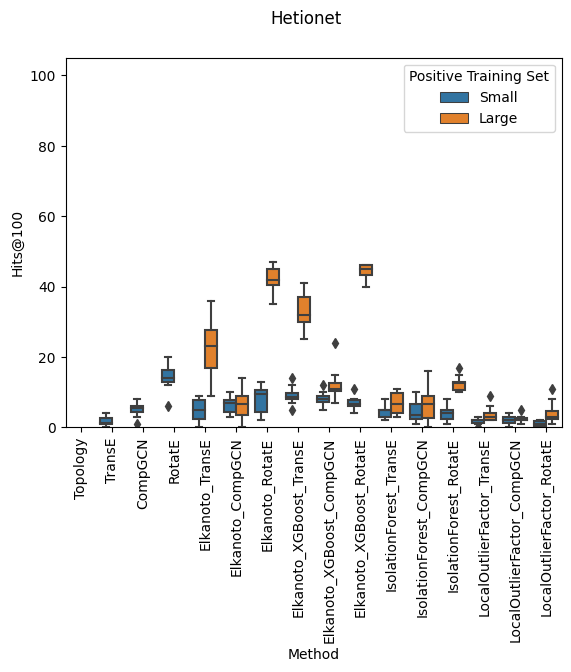

In [11]:
g_name, g_df = grps[0]
fig, ax = plot_df(g_df, g_name)
fig.savefig(f'{g_name}_hits100.png', bbox_inches='tight')
fig.savefig(f'{g_name}_hits100.tif', bbox_inches='tight')

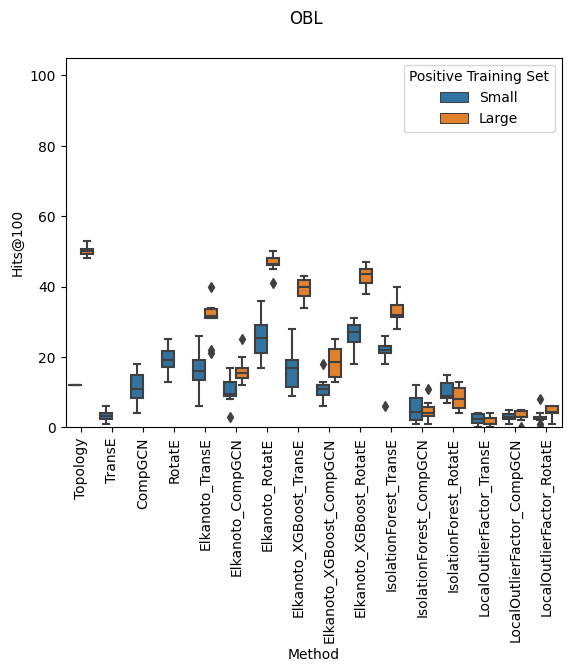

In [12]:
g_name, g_df = grps[1]

fig, ax = plot_df(g_df, g_name)
fig.savefig(f'{g_name}_hits100.png', bbox_inches='tight')
fig.savefig(f'{g_name}_hits100.tif', bbox_inches='tight')

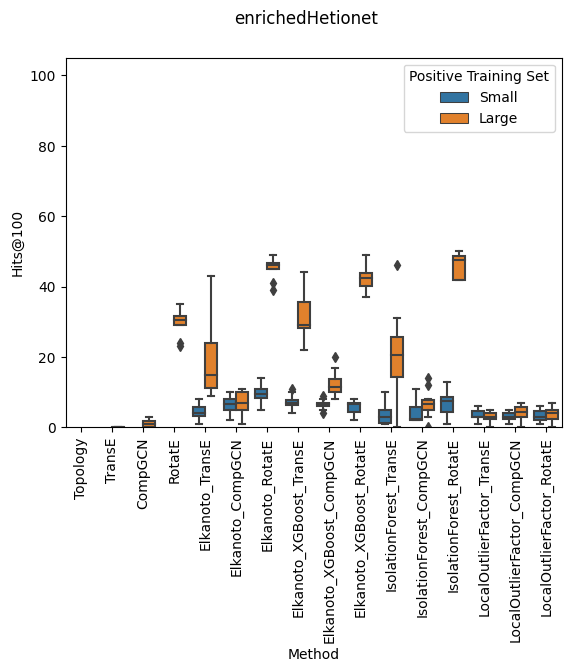

In [13]:
g_name, g_df = grps[2]

fig, ax = plot_df(g_df, g_name)
fig.savefig(f'{g_name}_hits100.png', bbox_inches='tight')
fig.savefig(f'{g_name}_hits100.tif', bbox_inches='tight')

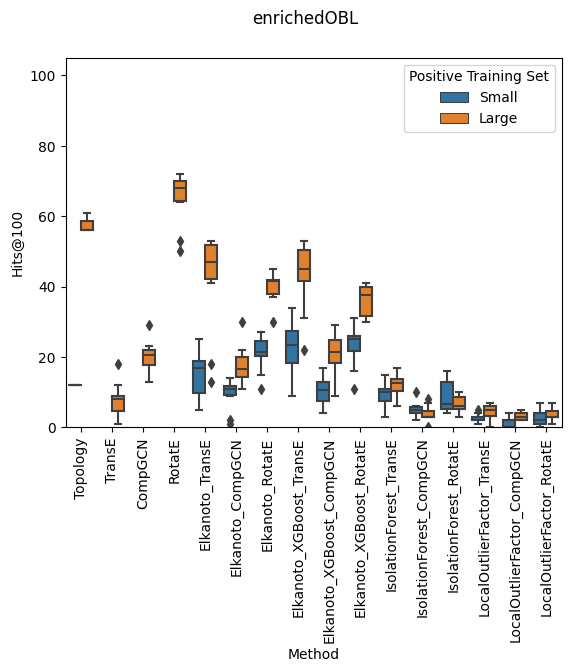

In [14]:
g_name, g_df = grps[3]

fig, ax = plot_df(g_df, g_name)
fig.savefig(f'{g_name}_hits100.png', bbox_inches='tight')
fig.savefig(f'{g_name}_hits100.tif', bbox_inches='tight')

In [15]:
df_het = df[df['Graph'].str.endswith('Hetionet')].copy()
df_het['Positive Training Set'] = df_het['Graph'] + ' ' + df_het['Positive Training Set']

df_obl = df[df['Graph'].str.endswith('OBL')].copy()
df_obl['Positive Training Set'] = df_obl['Graph'] + ' ' + df_obl['Positive Training Set']

def plot_graph_df(g_df, g_name, y_lim = (0, 105), y='Hits@100', hue_order=None):
    fig = plt.figure(figsize=(8,5))
    plot = sns.boxplot(g_df, y=y, x='Method', hue='Positive Training Set', hue_order=hue_order, palette='tab20')
    plot.set_xticklabels(labels=plot.get_xticklabels(), rotation=90)
    plot.set_ylim(y_lim)
    fig.suptitle(g_name)

    return fig, plot

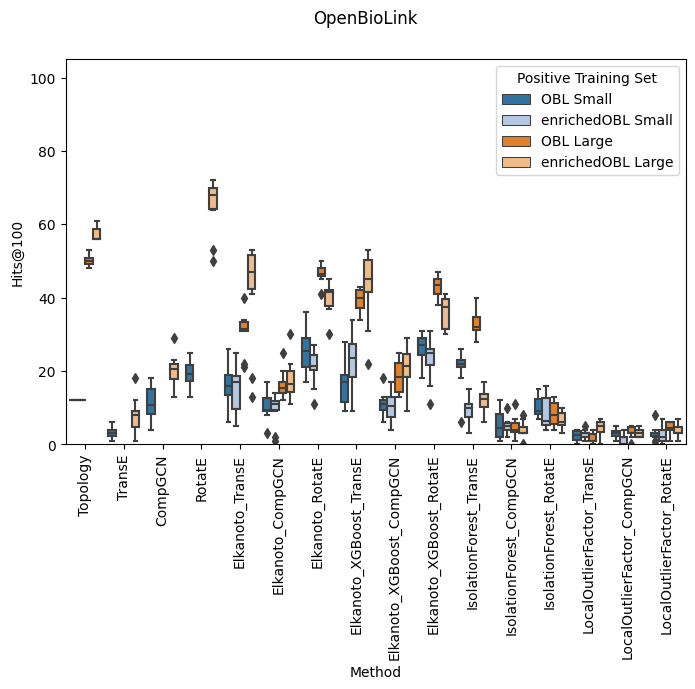

In [16]:
graph_name = 'OpenBioLink'
fig, ax = plot_graph_df(
    df_obl,
    g_name='OpenBioLink',
    hue_order=['OBL Small', 'enrichedOBL Small', 'OBL Large', 'enrichedOBL Large']
)
fig.savefig(f'{graph_name}_both_hits100.png', bbox_inches='tight')
fig.savefig(f'{graph_name}_both_hits100.tif', bbox_inches='tight')

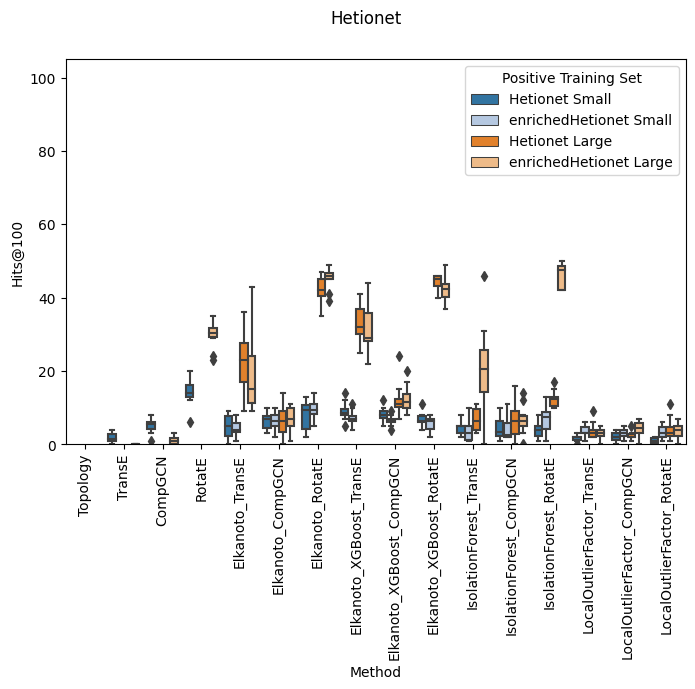

In [17]:
graph_name = 'Hetionet'
fig, ax = plot_graph_df(
    df_het,
    g_name='Hetionet',
    hue_order=['Hetionet Small', 'enrichedHetionet Small', 'Hetionet Large', 'enrichedHetionet Large']
)
fig.savefig(f'{graph_name}_both_hits100.png', bbox_inches='tight')
fig.savefig(f'{graph_name}_both_hits100.tif', bbox_inches='tight')

In [18]:
dd = {
    'Graph': [],
    'Positive Set': [],
    'Output Set': [],
    'Method': [],
    'Embedding Method': [],
    'Learner': [],
    'Distance_unknown': [],
    'Distance_irr': [],
}
for g in graphs:
    for ts in test_sets:
        for m in methods:
            for o_set in output_sets:
                distance_file = scores_dir / g / ts / m / o_set / 'distances_aggregated.csv'
                if not distance_file.exists():
                    dd['Graph'].append(g)
                    dd['Positive Set'].append(test_set_map[ts])
                    dd['Output Set'].append(output_set_map[o_set])
                    dd['Method'].append(m)
                    dd['Embedding Method'].append(get_embedding_method(m))
                    dd['Learner'].append(get_learner_method(m))
                    dd['Distance_unknown'].append(None)
                    dd['Distance_irr'].append(None)
                else:
                    d_df = pd.read_csv(distance_file)
                    for i in range(1,11):
                        dd['Graph'].append(g)
                        dd['Positive Set'].append(test_set_map[ts])
                        dd['Output Set'].append(output_set_map[o_set])
                        dd['Method'].append(m)
                        dd['Embedding Method'].append(get_embedding_method(m))
                        dd['Learner'].append(get_learner_method(m))
                        dd['Distance_unknown'].append(d_df.iloc[i, 1])
                        dd['Distance_irr'].append(d_df.iloc[i, 2])
                
d_df = pd.DataFrame(dd)
d_df

,Graph,Positive Set,Output Set,Method,Embedding Method,Learner,Distance_unknown,Distance_irr
0,Hetionet,Small,Test,Topology,Topology,Topology,NaN,NaN
1,Hetionet,Small,Test,TransE,TransE,TransE,0.320643,0.383462
2,Hetionet,Small,Test,TransE,TransE,TransE,0.755831,0.710801
3,Hetionet,Small,Test,TransE,TransE,TransE,0.551379,0.661792
4,Hetionet,Small,Test,TransE,TransE,TransE,0.115491,-0.028095
...,...,...,...,...,...,...,...,...
231,enrichedOBL,Large,Test,IsolationForest_CompGCN,CompGCN,IsolationForest,NaN,NaN
232,enrichedOBL,Large,Test,IsolationForest_RotatE,RotatE,IsolationForest,NaN,NaN
233,enrichedOBL,Large,Test,LocalOutlierFactor_TransE,TransE,LocalOutlierFactor,NaN,NaN
234,enrichedOBL,Large,Test,LocalOutlierFactor_CompGCN,CompGCN,LocalOutlierFactor,NaN,NaN


In [19]:
d_df.query('not Distance_irr.isna()')

,Graph,Positive Set,Output Set,Method,Embedding Method,Learner,Distance_unknown,Distance_irr
1,Hetionet,Small,Test,TransE,TransE,TransE,0.320643,0.383462
2,Hetionet,Small,Test,TransE,TransE,TransE,0.755831,0.710801
3,Hetionet,Small,Test,TransE,TransE,TransE,0.551379,0.661792
4,Hetionet,Small,Test,TransE,TransE,TransE,0.115491,-0.028095
5,Hetionet,Small,Test,TransE,TransE,TransE,0.460628,0.472732
...,...,...,...,...,...,...,...,...
219,enrichedOBL,Large,Test,RotatE,RotatE,RotatE,0.937522,0.426290
220,enrichedOBL,Large,Test,RotatE,RotatE,RotatE,0.742091,0.542866
221,enrichedOBL,Large,Test,RotatE,RotatE,RotatE,0.705518,0.404667
222,enrichedOBL,Large,Test,RotatE,RotatE,RotatE,0.764011,0.584685


In [21]:
var_name = 'Distances from gene set'
value_name = 'Normalised Euclidean Distance'

plot_df = d_df.melt(
    id_vars=['Graph', 'Method', 'Positive Set'],
    value_vars=['Distance_unknown', 'Distance_irr'],
    value_name=value_name,
    var_name=var_name
)
plot_df['Positive Training Set'] = plot_df['Positive Set']
plot_df['Distances from gene set'] = plot_df['Distances from gene set'].map({'Distance_unknown': 'unknown', 'Distance_irr': 'IR related'})
plot_df

,Graph,Method,Positive Set,Distances from gene set,Normalised Euclidean Distance,Positive Training Set
0,Hetionet,Topology,Small,unknown,NaN,Small
1,Hetionet,TransE,Small,unknown,0.320643,Small
2,Hetionet,TransE,Small,unknown,0.755831,Small
3,Hetionet,TransE,Small,unknown,0.551379,Small
4,Hetionet,TransE,Small,unknown,0.115491,Small
...,...,...,...,...,...,...
467,enrichedOBL,IsolationForest_CompGCN,Large,IR related,NaN,Large
468,enrichedOBL,IsolationForest_RotatE,Large,IR related,NaN,Large
469,enrichedOBL,LocalOutlierFactor_TransE,Large,IR related,NaN,Large
470,enrichedOBL,LocalOutlierFactor_CompGCN,Large,IR related,NaN,Large


In [29]:
def plot_distances(plot_df, model_name, graph_names, ylim, ax=None):
    plot = sns.boxplot(
        plot_df.query('Method == @model_name and Graph.isin(@graph_names)'), y=value_name, x='Positive Training Set', hue=var_name, ax=ax
    )
    plot.set_title(f'{graph_names[0]} - {model_name}')
    plot.set_ylim(ylim)

    return plot, ax

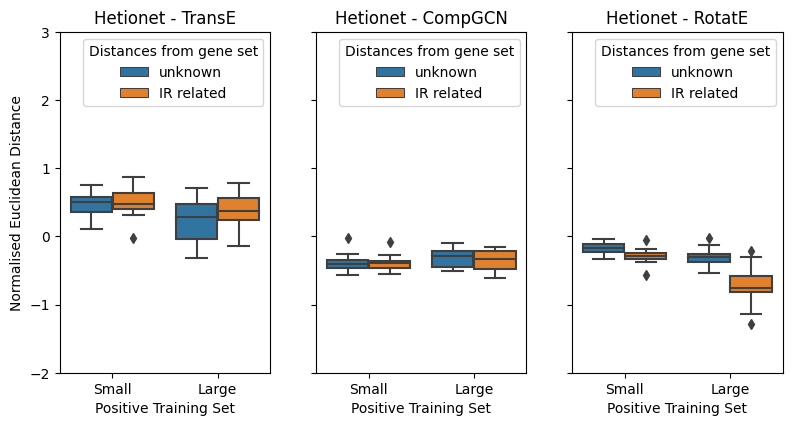

In [69]:
fig, axs = plt.subplots(1,3, sharey=True, figsize=(8,4))
fig.tight_layout()

graph_names = ['Hetionet', 'enrichedHetionet']
ylim = [-2, 3]
plot, ax = plot_distances(plot_df, model_name='TransE', graph_names=graph_names, ylim=ylim, ax=axs[0])
plot, ax = plot_distances(plot_df, model_name='CompGCN', graph_names=graph_names, ylim=ylim, ax=axs[1])
plot.set_ylabel('')
plot, ax = plot_distances(plot_df, model_name='RotatE', graph_names=graph_names, ylim=ylim, ax=axs[2])
plot.set_ylabel('')


fig.savefig('distances_Hetionet.png', bbox_inches='tight')
fig.savefig('distances_Hetionet.tif', bbox_inches='tight')

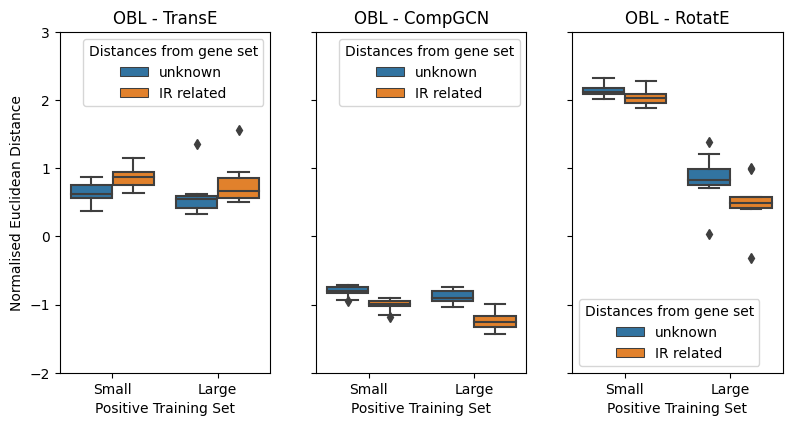

In [70]:
fig, axs = plt.subplots(1,3, sharey=True, figsize=(8,4))
fig.tight_layout()

graph_names = ['OBL', 'enrichedOBL']
ylim = [-2, 3]
plot_distances(plot_df, model_name='TransE', graph_names=graph_names, ylim=ylim, ax=axs[0])
plot, ax = plot_distances(plot_df, model_name='CompGCN', graph_names=graph_names, ylim=ylim, ax=axs[1])
plot.set_ylabel('')
plot, ax = plot_distances(plot_df, model_name='RotatE', graph_names=graph_names, ylim=ylim, ax=axs[2])
plot.set_ylabel('')

fig.savefig('distances_OBL.png', bbox_inches='tight')
fig.savefig('distances_OBL.tif', bbox_inches='tight')

In [57]:
def plot_distances2(plot_df, model_name, graph_names, ylim, ax=None):
    plot = sns.boxplot(
        plot_df.query('Method == @model_name and Graph.isin(@graph_names)'), y=value_name, x='Positive Training Set', hue=var_name, ax=ax
    )
    plot.set_ylim(ylim)
    plot.set_xlabel(model_name)

    return plot, ax

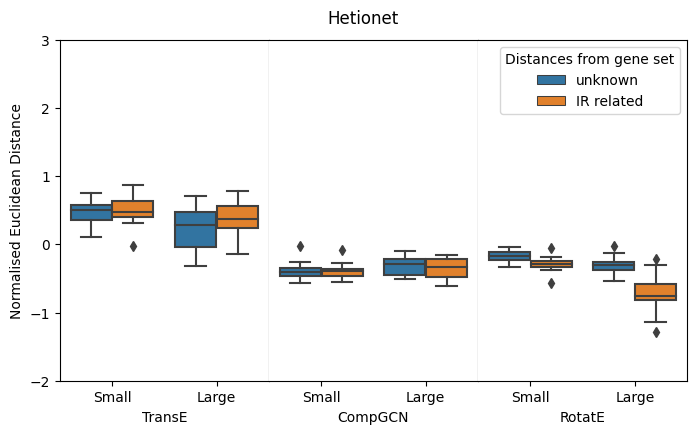

In [71]:
fig, axs = plt.subplots(1,3, sharey=True, figsize=(7,4))
fig.tight_layout()
fig.subplots_adjust(wspace=0)
fig.suptitle('Hetionet', y=1.025)

graph_names = ['Hetionet', 'enrichedHetionet']
ylim = [-2, 3]
plot, ax = plot_distances2(plot_df, model_name='TransE', graph_names=graph_names, ylim=ylim, ax=axs[0])
ax.legend().remove()
plot, ax = plot_distances2(plot_df, model_name='CompGCN', graph_names=graph_names, ylim=ylim, ax=axs[1])
ax.spines['left'].set_visible(False)
ax.tick_params(axis='both',which='both',left=False)
ax.legend().remove()
plot.set_ylabel('')
plot, ax = plot_distances2(plot_df, model_name='RotatE', graph_names=graph_names, ylim=ylim, ax=axs[2])
ax.spines['left'].set_visible(False)
ax.tick_params(axis='both',which='both',left=False)
plot.set_ylabel('')



fig.savefig('distances_Hetionet_oneplot.png', bbox_inches='tight')
fig.savefig('distances_Hetionet_oneplot.tif', bbox_inches='tight')

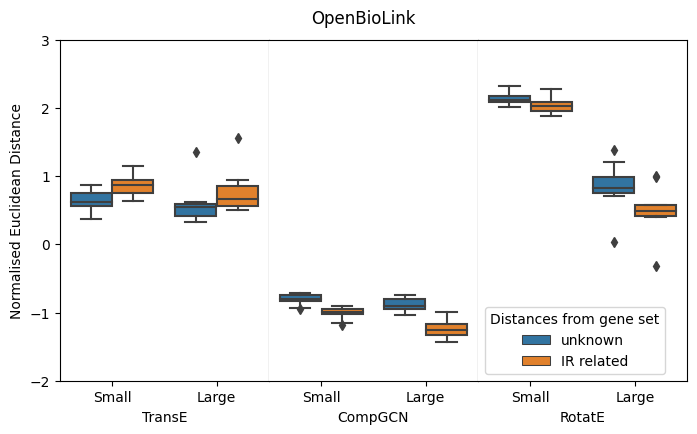

In [72]:
fig, axs = plt.subplots(1,3, sharey=True, figsize=(7,4))
fig.tight_layout()
fig.subplots_adjust(wspace=0)
fig.suptitle('OpenBioLink', y=1.025)

graph_names = ['OBL', 'enrichedOBL']
ylim = [-2, 3]
plot, ax = plot_distances2(plot_df, model_name='TransE', graph_names=graph_names, ylim=ylim, ax=axs[0])
ax.legend().remove()
plot, ax = plot_distances2(plot_df, model_name='CompGCN', graph_names=graph_names, ylim=ylim, ax=axs[1])
ax.spines['left'].set_visible(False)
ax.tick_params(axis='both',which='both',left=False)
ax.legend().remove()
plot.set_ylabel('')
plot, ax = plot_distances2(plot_df, model_name='RotatE', graph_names=graph_names, ylim=ylim, ax=axs[2])
ax.spines['left'].set_visible(False)
ax.tick_params(axis='both',which='both',left=False)
plot.set_ylabel('')



fig.savefig('distances_OBL_oneplot.png', bbox_inches='tight')
fig.savefig('distances_OBL_oneplot.tif', bbox_inches='tight')